In [1]:
#Notes Anna - 2016_09_30
#Perform the gene expression normalization before you add the pseudocount
#Gene expression normalization must be gene expression pseudocount because you can't divide by 0

#the point of this is to generate a master_dataframe_that_contains_binding
#information as well as gene expression information to allow for separating
#into interesting groups

#Note on gene expression normalization - there is also a problem with my gene level normalization... Does it make sense to divide essentially a TPM value in the iCLIP data by FPKM from the sample? The FPKM value comes from cuffdiff - so is it comparable between samples? The total FPKMs do not fully add up

#I will also plot the data normalized by gene expression and not normalized by gene expression
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from math import *
from subprocess import *
import pybedtools as pbt
from glob import glob
import seaborn as sns
import statsmodels.formula.api as sm
%matplotlib inline
#take the final union bedgraph and import to pandas so I can calculate the fold change and log2ratio of the samples
header_list=['chrom','start','end','hnM_DMSO','hnM_TAM']
hnM_DMSO_TAM_final_union_df = pd.read_csv('hnM_DMSO_TAM_merge_final_union.bg',sep='\t',names=header_list)
hnM_DMSO_TAM_final_union_df['hnM_DMSO_1'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: row['hnM_DMSO']+1,axis=1)
hnM_DMSO_TAM_final_union_df['hnM_TAM_1'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: row['hnM_TAM']+1,axis=1)
hnM_DMSO_TAM_final_union_df['log2ratio_TAM-DMSO'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: (log(row['hnM_TAM']+1,2)-log(row['hnM_DMSO']+1,2)),axis=1)
#now I need to generate a bedtool and intersect with the FAST-iCLIP genes file
#Note - I am concerned that the clipper file does not match the RT stops - need to take a look at how Brian extracted these.
#print a file and get it the dataframe as a bedtool
hnM_DMSO_TAM_final_union_df.to_csv('hnM_DMSO_TAM_final_union_with_log2ratio',sep='\t',index=False,header=False)
hnM_DMSO_TAM_final_df_bt = pbt.BedTool(fn='hnM_DMSO_TAM_final_union_with_log2ratio')
#other idea - just overlap with genes without strandedness and then merge so that
#the gene name contains both genes
hg19_ensembl_genes = pbt.BedTool(fn='/Users/Sam/bin/FAST-iCLIP/docs/hg19_ensembl_genes_BED6.bed')
#merge this so that gene names overlap
# hg19_ensembl_genes_merge = hg19_ensembl_genes.merge(c=4,o='distinct',s=True).saveas('hg19_ensembl_genes_merge')
#intersect with hnM_DMSO_TAM_final
hnM_DMSO_TAM_final_hg19_ensembl_genes_intersect = hnM_DMSO_TAM_final_df_bt.intersect(b=hg19_ensembl_genes,wao=True).saveas('hnM_DMSO_TAM_final_hg19_ensembl_genes_intersect')
#now merge this on columns 4,5,6,7,8,12
hnM_DMSO_TAM_final_hg19_ensembl_genes_intersect_merge = hnM_DMSO_TAM_final_hg19_ensembl_genes_intersect.merge(c=[4,5,6,7,8,12],o='distinct').saveas('hnM_DMSO_TAM_final_hg19_ensembl_genes_intersect_merge')
#now read this in as a dataframe
header_list=['chrom','start','end','hnM_DMSO','hnM_TAM','hnM_DMSO_1','hnM_TAM_1','log2ratio_TAM_DMSO','ens_gene']
hnM_DMSO_TAM_final_union_genes_df = pd.read_csv('hnM_DMSO_TAM_final_hg19_ensembl_genes_intersect_merge',sep='\t',names = header_list)
#now it is time to load the gene expression data
twist_gene_exp_df = pd.read_csv('twist_gene_exp.diff',sep='\t',usecols=[1,2,3,7,8],header=0, names=['ens_gene','gene','gene_coords','twist_d0','twist_d14'])
#now I need to merge the dataframes based on the column ens_gene. The problem is
#that ens_gene is not unique, so there is a loss of clusters
#This merge command just keeps all of the columns that agree on ens_gene
merge_df = pd.merge(hnM_DMSO_TAM_final_union_genes_df,twist_gene_exp_df,on='ens_gene')
#You've got to go back and fix this later... deal with the duplicates somehow
#now add a column with +1 for each and log2ratio
merge_df['twist_d0_1'] = merge_df.apply(lambda row: row['twist_d0']+1,axis=1)
merge_df['twist_d14_1'] = merge_df.apply(lambda row: row['twist_d14']+1,axis=1)
merge_df['log2ratio_d14_d0'] = merge_df.apply(lambda row: (log(row['twist_d14']+1,2)-log(row['twist_d0']+1,2)),axis=1)


#now sort out the different categories with 2 fold (0.5) thresholds
#Remember --> I did not normalize binding intensity based on gene expression
#because there is not a perfect correlation here. Instead, look for opposite relationships


#Keep rows with FPKM threshold or more in at least one sample
#Make sure that you use "or" because you want FPKM 5 in at least one sample
#fpkm_threshold = 5
#merge_df_high_genes = merge_df[(merge_df.twist_d0 >= fpkm_threshold) | (merge_df.twist_d14 >= fpkm_threshold)]

# #set a log2 fold_change ratio and print different groups
# threshold = 0.5
# comparison_list = []

# #1. no binding changes, no gene expression changes
# merge_df_no_bind_no_gene = merge_df[merge_df.log2ratio_TAM_DMSO.abs() < threshold]
# merge_df_no_bind_no_gene = merge_df_no_bind_no_gene[merge_df_no_bind_no_gene.log2ratio_d14_d0.abs() < threshold]
# merge_df_no_bind_no_gene.to_csv('comparison_df/no_bind_no_gene',sep='\t',index=False)

# #2. binding changes, no gene expression changes
# merge_df_bind_no_gene = merge_df[merge_df.log2ratio_d14_d0.abs() < threshold]
# merge_df_bind_no_gene = merge_df_bind_no_gene[merge_df_bind_no_gene.log2ratio_TAM_DMSO.abs() >= threshold]
# merge_df_bind_no_gene.to_csv('comparison_df/bind_no_gene',sep='\t',index=False)

# #3. no binding changes, gene expression changes
# merge_df_no_bind_gene = merge_df_high_genes[merge_df_high_genes.log2ratio_TAM_DMSO.abs() < threshold]
# merge_df_no_bind_gene = merge_df_no_bind_gene[merge_df_no_bind_gene.log2ratio_d14_d0.abs() >= threshold]
# merge_df_no_bind_gene.to_csv('comparison_df/no_bind_gene',sep='\t',index=False)

# #4. binding changes, gene expression changes
# merge_df_bind_gene = merge_df_high_genes[merge_df_high_genes.log2ratio_TAM_DMSO.abs() >= threshold]
# merge_df_bind_gene = merge_df_bind_gene[merge_df_bind_gene.log2ratio_d14_d0.abs() >= threshold]
# merge_df_bind_gene.to_csv('comparison_df/bind_gene',sep='\t',index=False)

# #now we should further sort the genes in the following
# #bind_gene - bind is >= 0.5, but gene < 0.5
# merge_df_bind_up_gene_down = merge_df_bind_gene[merge_df_bind_gene.log2ratio_TAM_DMSO >= 0.5]
# merge_df_bind_up_gene_down = merge_df_bind_up_gene_down[merge_df_bind_up_gene_down.log2ratio_d14_d0 < 0.5]
# merge_df_bind_up_gene_down.to_csv('comparison_df/bind_up_gene_down',sep='\t',index=False)
# #bind_gene - bind is < 0.5, but gene >= 0.5
# merge_df_bind_down_gene_up = merge_df_bind_gene[merge_df_bind_gene.log2ratio_TAM_DMSO < 0.5]
# merge_df_bind_down_gene_up = merge_df_bind_down_gene_up[merge_df_bind_down_gene_up.log2ratio_d14_d0 >= 0.5]
# merge_df_bind_down_gene_up.to_csv('comparison_df/bind_down_gene_up',sep='\t',index=False)

# # #write to excel
# # writer = pd.ExcelWriter('~/Desktop/comparison_excel.xlsx')
# # merge_df_no_bind_no_gene.to_excel(writer,'no_bind_no_gene')
# # merge_df_bind_no_gene.to_excel(writer,'bind_no_gene')
# # merge_df_no_bind_gene.to_excel(writer,'no_bind_gene')
# # merge_df_bind_gene.to_excel(writer,'bind_gene')
# # merge_df_bind_up_gene_down.to_excel(writer,'bind_up_gene_down')
# # merge_df_bind_down_gene_up.to_excel(writer,'bind_down_gene_up')


In [3]:
#Keep rows with FPKM threshold or more in at least one sample
#Make sure that you use "or" because you want FPKM 5 in at least one sample
fpkm_threshold = 5
merge_df_high_genes = merge_df[(merge_df.twist_d0 >= fpkm_threshold) | (merge_df.twist_d14 >= fpkm_threshold)]

In [4]:
merge_df_high_genes[0:4]

,chrom,start,end,hnM_DMSO,hnM_TAM,hnM_DMSO_1,hnM_TAM_1,log2ratio_TAM_DMSO,ens_gene,gene,gene_coords,twist_d0,twist_d14,twist_d0_1,twist_d14_1,log2ratio_d14_d0
11,chr1,764904,764905,4.375251,0.000000,5.375251,1.000000,-2.426332,ENSG00000228794,RP11-206L10.11,chr1:762987-794826,4.36045,6.42322,5.36045,7.42322,0.469691
12,chr1,765188,765196,12.031940,0.000000,13.031940,1.000000,-3.703980,ENSG00000228794,RP11-206L10.11,chr1:762987-794826,4.36045,6.42322,5.36045,7.42322,0.469691
13,chr1,765396,765416,7.656689,19.363538,8.656689,20.363538,1.234101,ENSG00000228794,RP11-206L10.11,chr1:762987-794826,4.36045,6.42322,5.36045,7.42322,0.469691
14,chr1,765432,765433,6.562876,0.000000,7.562876,1.000000,-2.918935,ENSG00000228794,RP11-206L10.11,chr1:762987-794826,4.36045,6.42322,5.36045,7.42322,0.469691


In [5]:
merge_df_high_genes.describe()

,start,end,hnM_DMSO,hnM_TAM,hnM_DMSO_1,hnM_TAM_1,log2ratio_TAM_DMSO,twist_d0,twist_d14,twist_d0_1,twist_d14_1,log2ratio_d14_d0
count,1.178760e+05,1.178760e+05,117876.000000,117876.000000,117876.000000,117876.000000,117876.000000,117876.000000,117876.000000,117876.000000,117876.000000,117876.000000
mean,7.880539e+07,7.880541e+07,61.463067,58.278584,62.463067,59.278584,-0.353184,46.553728,57.520985,47.553728,58.520985,-0.200365
std,5.707530e+07,5.707530e+07,245.075610,319.679063,245.075610,319.679063,3.798749,211.136443,377.677526,211.136443,377.677526,1.165608
min,4.466900e+04,4.467000e+04,0.000000,0.000000,1.000000,1.000000,-12.978950,0.000000,0.000000,1.000000,1.000000,-6.460721
25%,3.386842e+07,3.386842e+07,0.000000,0.000000,1.000000,1.000000,-3.285476,7.991030,5.544970,8.991030,6.544970,-0.993722
50%,6.774530e+07,6.774534e+07,10.938127,10.561930,11.938127,11.561930,-0.547510,14.016300,12.096800,15.016300,13.096800,-0.273144
75%,1.163425e+08,1.163425e+08,49.221572,38.727076,50.221572,39.727076,3.293018,30.968400,31.422700,31.968400,32.422700,0.539653
max,2.491478e+08,2.491478e+08,31872.608450,60588.510730,31873.608450,60589.510730,11.188234,9036.280000,11000.600000,9037.280000,11001.600000,8.790504


In [6]:
len(merge_df)

172631

In [7]:
len(merge_df_high_genes)

117876

In [9]:
#lengths - shows how much is lost
print(len(hnM_DMSO_TAM_final_union_df),len(twist_gene_exp_df),len(merge_df))

(190938, 57146, 172631)


,start,end,hnM_DMSO,hnM_TAM,hnM_DMSO_1,hnM_TAM_1,log2ratio_TAM-DMSO
start,1.000000,1.000000,-0.003897,-0.002235,-0.003897,-0.002235,0.014556
end,1.000000,1.000000,-0.003897,-0.002235,-0.003897,-0.002235,0.014556
hnM_DMSO,-0.003897,-0.003897,1.000000,0.813531,1.000000,0.813531,-0.092806
hnM_TAM,-0.002235,-0.002235,0.813531,1.000000,0.813531,1.000000,0.090004
hnM_DMSO_1,-0.003897,-0.003897,1.000000,0.813531,1.000000,0.813531,-0.092806
hnM_TAM_1,-0.002235,-0.002235,0.813531,1.000000,0.813531,1.000000,0.090004
log2ratio_TAM-DMSO,0.014556,0.014556,-0.092806,0.090004,-0.092806,0.090004,1.000000


/Users/Sam/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


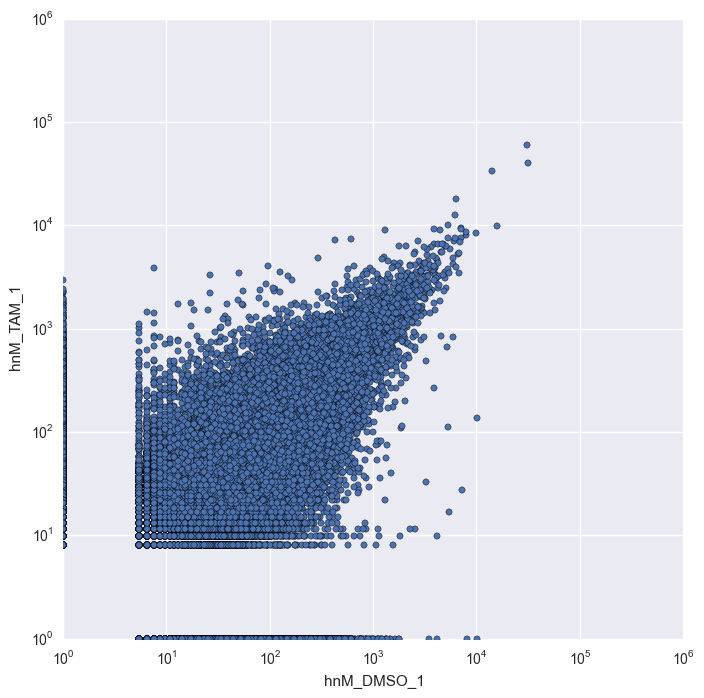

In [10]:
#No gene expression normalization
ax_none_gene_norm = hnM_DMSO_TAM_final_union_df.plot(kind='scatter',x='hnM_DMSO_1',y='hnM_TAM_1',figsize=(8,8),loglog=True,xlim=(1,10e5),ylim=(1,10e5))
hnM_DMSO_TAM_final_union_df.corr()

In [44]:
merge_df_high_genes[0:3]

,chrom,start,end,hnM_DMSO,hnM_TAM,hnM_DMSO_1,hnM_TAM_1,log2ratio_TAM_DMSO,ens_gene,gene,gene_coords,twist_d0,twist_d14,twist_d0_1,twist_d14_1,log2ratio_d14_d0,hnM_TAM_1_gene_norm
22,chr1,890202,890203,13.125752,12.322252,14.125752,13.322252,-0.084490,ENSG00000188976,NOC2L,chr1:860259-894689,59.7222,106.213,60.7222,107.213,0.820184,7.54532
23,chr1,890741,890742,10.938127,0.000000,11.938127,1.000000,-3.577505,ENSG00000188976,NOC2L,chr1:860259-894689,59.7222,106.213,60.7222,107.213,0.820184,0.56637
24,chr1,890776,890784,12.031940,0.000000,13.031940,1.000000,-3.703980,ENSG00000188976,NOC2L,chr1:860259-894689,59.7222,106.213,60.7222,107.213,0.820184,0.56637


/Users/Sam/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Sam/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Sam/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/index

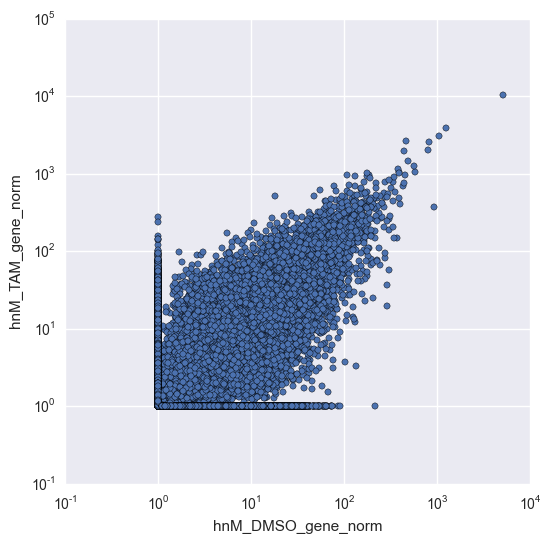

In [16]:
#THIS IS THE CORRECT ONE!
#Here we take the non-pseudocount values for binding and the pseudocount+1 for gene expression and divide 
#non-pseudocount binding / pseudocount gene expression from that same sample. 
#Then add the pseudocount of 1 to the binding so you can plot on log scale

#now divide by the gene expression in each sample 
#with gene expression normalization - make sure to only use dataframe with genes that are expressed in at least one 
#condition at threshold
# merge_df_high_genes['hnM_DMSO_1_gene_norm'] = 
merge_df_high_genes['hnM_DMSO_gene_norm']= merge_df_high_genes.apply(lambda row: ((row['hnM_DMSO']) / (row['twist_d0_1'])+1),axis=1)
merge_df_high_genes['hnM_TAM_gene_norm'] = merge_df_high_genes.apply(lambda row: ((row['hnM_TAM']) / (row['twist_d14_1'])+1),axis=1)
#calculate log2ratio of this 
merge_df_high_genes['log2ratio_hnM_TAM_DMSO_gene_norm'] = merge_df_high_genes.apply(lambda row:(log(row['hnM_TAM_gene_norm'],2)-log(row['hnM_DMSO_gene_norm'],2)),axis=1)
#plot a scatter plot
ax_with_gene_norm = merge_df_high_genes.plot(kind='scatter',x='hnM_DMSO_gene_norm',y='hnM_TAM_gene_norm',figsize=(6,6),loglog=True)

In [12]:
merge_df_high_genes.describe()

,start,end,hnM_DMSO,hnM_TAM,hnM_DMSO_1,hnM_TAM_1,log2ratio_TAM_DMSO,twist_d0,twist_d14,twist_d0_1,twist_d14_1,log2ratio_d14_d0,hnM_DMSO_gene_norm,hnM_TAM_gene_norm
count,1.178760e+05,1.178760e+05,117876.000000,117876.000000,117876.000000,117876.000000,117876.000000,117876.000000,117876.000000,117876.000000,117876.000000,117876.000000,117876.000000,117876.000000
mean,7.880539e+07,7.880541e+07,61.463067,58.278584,62.463067,59.278584,-0.353184,46.553728,57.520985,47.553728,58.520985,-0.200365,4.955053,7.060074
std,5.707530e+07,5.707530e+07,245.075610,319.679063,245.075610,319.679063,3.798749,211.136443,377.677526,211.136443,377.677526,1.165608,20.704686,44.101724
min,4.466900e+04,4.467000e+04,0.000000,0.000000,1.000000,1.000000,-12.978950,0.000000,0.000000,1.000000,1.000000,-6.460721,1.000000,1.000000
25%,3.386842e+07,3.386842e+07,0.000000,0.000000,1.000000,1.000000,-3.285476,7.991030,5.544970,8.991030,6.544970,-0.993722,1.000000,1.000000
50%,6.774530e+07,6.774534e+07,10.938127,10.561930,11.938127,11.561930,-0.547510,14.016300,12.096800,15.016300,13.096800,-0.273144,1.612465,1.444286
75%,1.163425e+08,1.163425e+08,49.221572,38.727076,50.221572,39.727076,3.293018,30.968400,31.422700,31.968400,32.422700,0.539653,4.049386,4.227661
max,2.491478e+08,2.491478e+08,31872.608450,60588.510730,31873.608450,60589.510730,11.188234,9036.280000,11000.600000,9037.280000,11001.600000,8.790504,5157.492869,10317.028415


In [17]:
merge_df_high_genes.head()

,chrom,start,end,hnM_DMSO,hnM_TAM,hnM_DMSO_1,hnM_TAM_1,log2ratio_TAM_DMSO,ens_gene,gene,gene_coords,twist_d0,twist_d14,twist_d0_1,twist_d14_1,log2ratio_d14_d0,hnM_TAM_1_gene_norm,hnM_DMSO_gene_norm,hnM_TAM_gene_norm,log2ratio_hnM_TAM_DMSO_gene_norm
11,chr1,764904,764905,4.375251,0.000000,5.375251,1.000000,-2.426332,ENSG00000228794,RP11-206L10.11,chr1:762987-794826,4.36045,6.42322,5.36045,7.42322,0.469691,0.722119,1.816210,1.000000,-0.860931
12,chr1,765188,765196,12.031940,0.000000,13.031940,1.000000,-3.703980,ENSG00000228794,RP11-206L10.11,chr1:762987-794826,4.36045,6.42322,5.36045,7.42322,0.469691,0.722119,3.244576,1.000000,-1.698030
13,chr1,765396,765416,7.656689,19.363538,8.656689,20.363538,1.234101,ENSG00000228794,RP11-206L10.11,chr1:762987-794826,4.36045,6.42322,5.36045,7.42322,0.469691,14.704903,2.428367,3.608509,0.571417
14,chr1,765432,765433,6.562876,0.000000,7.562876,1.000000,-2.918935,ENSG00000228794,RP11-206L10.11,chr1:762987-794826,4.36045,6.42322,5.36045,7.42322,0.469691,0.722119,2.224314,1.000000,-1.153361
15,chr1,766263,766264,7.656689,0.000000,8.656689,1.000000,-3.113815,ENSG00000228794,RP11-206L10.11,chr1:762987-794826,4.36045,6.42322,5.36045,7.42322,0.469691,0.722119,2.428367,1.000000,-1.279986


In [23]:
#try to make a prettier figure with colors
#get a dataframe with log2ratio_hnM_TAM_DMSO_gene_norm > or < 0.5
tam_bound = merge_df_high_genes[merge_df_high_genes.log2ratio_hnM_TAM_DMSO_gene_norm >= 1]
dmso_bound = merge_df_high_genes[merge_df_high_genes.log2ratio_hnM_TAM_DMSO_gene_norm <= -1]
non_diff_bound = merge_df_high_genes[merge_df_high_genes.log2ratio_hnM_TAM_DMSO_gene_norm.abs() <= 1]


In [24]:
non_diff_bound.head()

,chrom,start,end,hnM_DMSO,hnM_TAM,hnM_DMSO_1,hnM_TAM_1,log2ratio_TAM_DMSO,ens_gene,gene,gene_coords,twist_d0,twist_d14,twist_d0_1,twist_d14_1,log2ratio_d14_d0,hnM_TAM_1_gene_norm,hnM_DMSO_gene_norm,hnM_TAM_gene_norm,log2ratio_hnM_TAM_DMSO_gene_norm
11,chr1,764904,764905,4.375251,0.000000,5.375251,1.000000,-2.426332,ENSG00000228794,RP11-206L10.11,chr1:762987-794826,4.36045,6.42322,5.36045,7.42322,0.469691,0.722119,1.816210,1.000000,-0.860931
13,chr1,765396,765416,7.656689,19.363538,8.656689,20.363538,1.234101,ENSG00000228794,RP11-206L10.11,chr1:762987-794826,4.36045,6.42322,5.36045,7.42322,0.469691,14.704903,2.428367,3.608509,0.571417
20,chr1,767223,767224,0.000000,7.041287,1.000000,8.041287,3.007426,ENSG00000228794,RP11-206L10.11,chr1:762987-794826,4.36045,6.42322,5.36045,7.42322,0.469691,5.806768,1.000000,1.948549,0.962400
22,chr1,890202,890203,13.125752,12.322252,14.125752,13.322252,-0.084490,ENSG00000188976,NOC2L,chr1:860259-894689,59.72220,106.21300,60.72220,107.21300,0.820184,7.545320,1.216161,1.114932,-0.125378
23,chr1,890741,890742,10.938127,0.000000,11.938127,1.000000,-3.577505,ENSG00000188976,NOC2L,chr1:860259-894689,59.72220,106.21300,60.72220,107.21300,0.820184,0.566370,1.180134,1.000000,-0.238951


count    117876.000000
mean         22.506227
std          42.449160
min           1.000000
25%           1.000000
50%           7.000000
75%          29.000000
max        1573.000000
dtype: float64

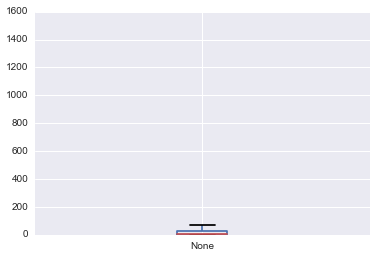

In [21]:
#Plot a boxplot of the cluster sizes
cluster_size = merge_df_high_genes['end']-merge_df_high_genes['start']
cluster_size.plot.box();cluster_size.describe()

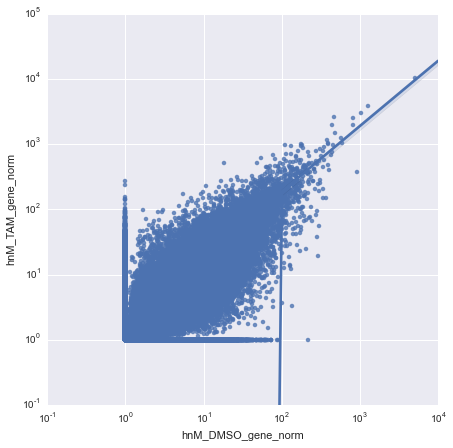

In [9]:
#Try plotting with seaborn - doesn't work
#set up matplotlib axes for the seaborn regression plot
f,ax = plt.subplots(figsize=(7,7))
ax.set(xscale='log',yscale='log')
sns.regplot("hnM_DMSO_gene_norm","hnM_TAM_gene_norm",merge_df_high_genes,ax=ax)

In [35]:
merge_df_high_genes[0:4]

,chrom,start,end,hnM_DMSO,hnM_TAM,hnM_DMSO_1,hnM_TAM_1,log2ratio_TAM_DMSO,ens_gene,gene,gene_coords,twist_d0,twist_d14,twist_d0_1,twist_d14_1,log2ratio_d14_d0,hnM_DMSO_gene_norm,hnM_TAM_gene_norm
11,chr1,764904,764905,4.375251,0.000000,5.375251,1.000000,-2.426332,ENSG00000228794,RP11-206L10.11,chr1:762987-794826,4.36045,6.42322,5.36045,7.42322,0.469691,1.816210,1.000000
12,chr1,765188,765196,12.031940,0.000000,13.031940,1.000000,-3.703980,ENSG00000228794,RP11-206L10.11,chr1:762987-794826,4.36045,6.42322,5.36045,7.42322,0.469691,3.244576,1.000000
13,chr1,765396,765416,7.656689,19.363538,8.656689,20.363538,1.234101,ENSG00000228794,RP11-206L10.11,chr1:762987-794826,4.36045,6.42322,5.36045,7.42322,0.469691,2.428367,14.982783
14,chr1,765432,765433,6.562876,0.000000,7.562876,1.000000,-2.918935,ENSG00000228794,RP11-206L10.11,chr1:762987-794826,4.36045,6.42322,5.36045,7.42322,0.469691,2.224314,1.000000


In [34]:
merge_df_high_genes.describe()

,start,end,hnM_DMSO,hnM_TAM,hnM_DMSO_1,hnM_TAM_1,log2ratio_TAM_DMSO,twist_d0,twist_d14,twist_d0_1,twist_d14_1,log2ratio_d14_d0,hnM_DMSO_gene_norm,hnM_TAM_gene_norm
count,1.178760e+05,1.178760e+05,117876.000000,117876.000000,117876.000000,117876.000000,117876.000000,117876.000000,117876.000000,117876.000000,117876.000000,117876.000000,117876.000000,117876.000000
mean,7.880539e+07,7.880541e+07,61.463067,58.278584,62.463067,59.278584,-0.353184,46.553728,57.520985,47.553728,58.520985,-0.200365,4.955053,87.864973
std,5.707530e+07,5.707530e+07,245.075610,319.679063,245.075610,319.679063,3.798749,211.136443,377.677526,211.136443,377.677526,1.165608,20.704686,459.893245
min,4.466900e+04,4.467000e+04,0.000000,0.000000,1.000000,1.000000,-12.978950,0.000000,0.000000,1.000000,1.000000,-6.460721,1.000000,1.000000
25%,3.386842e+07,3.386842e+07,0.000000,0.000000,1.000000,1.000000,-3.285476,7.991030,5.544970,8.991030,6.544970,-0.993722,1.000000,1.000000
50%,6.774530e+07,6.774534e+07,10.938127,10.561930,11.938127,11.561930,-0.547510,14.016300,12.096800,15.016300,13.096800,-0.273144,1.612465,10.073001
75%,1.163425e+08,1.163425e+08,49.221572,38.727076,50.221572,39.727076,3.293018,30.968400,31.422700,31.968400,32.422700,0.539653,4.049386,48.983617
max,2.491478e+08,2.491478e+08,31872.608450,60588.510730,31873.608450,60589.510730,11.188234,9036.280000,11000.600000,9037.280000,11001.600000,8.790504,5157.492869,62040.666447


In [42]:
merge_df_high_genes[:3]
len(merge_df_high_genes)

85685

In [39]:
#Purpose here was to do something about clusters that overlap with multiple genes that are filtered out
#note - it would be better for me to use the clipper assignment because it keeps the strand
#idea - take the clipper, pull out the genes, take only those genes from the hg19_ensembl_genes,
#then intersect
# gene_list=[]
# with open('hnM_DMSO_files/hnM_DMSO_clipper_lowFDRreads_centerCoord_collapse.bed') as infile:
#     readlines = infile.readlines()
#     for line in readlines:
#         line = line.strip().split('\t')
#         gene_list.append(line[3])
# simple_gene_list = []
# for item in gene_list:
#     gene = item.split('.')[0]
#     simple_gene_list.append(gene)
# with open('hnM_TAM_files/hnM_TAM_clipper_lowFDRreads_centerCoord_collapse.bed') as infile:
#     readlines = infile.readlines()
#     for line in readlines:
#         line = line.strip().split('\t')
#         gene_list.append(line[3])
# simple_gene_list = []
# for item in gene_list:
#     gene = item.split('.')[0]
#     simple_gene_list.append(gene)

# simple_gene_list = list(set(simple_gene_list))

# final_gene_list = []
# with open('/Users/Sam/bin/FAST-iCLIP/docs/hg19_ensembl_genes_BED6.bed') as infile:
#     readlines = infile.readlines()
#     for line in readlines:
#         gene = line.strip().split('\t')[3]
#         if gene in simple_gene_list:
#             final_gene_list.append(line)
            
# with open('hg19_ensembl_genes_from_hnM_DMSO_TAM_clipper')
                